# Main script to clean CA fires data

Modules: N/A <br>
Author: Cornelia Ilin <br>
Email: cilin@wisc.edu <br>
Date created: March 22, 2020 <br>

**Citations (data sources)**

``CA fires data:``
1. CAL Fire: Fire perimeters database: https://frap.fire.ca.gov/mapping/gis-data/
2. Data dictionary: https://frap.fire.ca.gov/frap-projects/fire-perimeters/

``Shapefiles for California ZIP codes (2010 census):``

Note: CAL Fire also has county bounderies info (check it here: https://frap.fire.ca.gov/mapping/gis-data/)

3. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas

4. How to find if a point is inside a polygon:<br>
https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon <br>
https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
    
**Citations (persons)**
1. N/A

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [7]:
# standard
import pandas as pd
import numpy as np
import os
from datetime import datetime

# geospatial
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

# ignore warnings
import warnings
warnings.filterwarnings(
    'ignore'
)

### Step 2: Define working directories

In [1]:
in_dir = 'C:/Users/cilin/Research/CA_hospitals/Input/raw_data/fires/'
out_dir = 'C:/Users/cilin/Research/CA_hospitals/Input/final_data/fires/'
in_dir_zcta_shapes = 'C:/Users/cilin/Research/CA_hospitals/Input/raw_data/census_geo/shapefiles_zcta/'
in_dir_county_shapes = 'C:/Users/cilin/Research/CA_hospitals/Input/raw_data/census_geo/shapefiles_county/'
in_dir_zcta_to_county = 'C:/Users/cilin/Research/CA_hospitals/Input/raw_data/census_geo/zcta_to_county/'

### Step 3: Define functions

```read data```

In [2]:
def read_fires():
    ''''''
    # read unprescribed fires data
    return gpd.read_file(
        in_dir + 'fire19_1.gdb', layer=1
    )
    
    # read prescribed fires data
    #return gpd.read_file(in_dir + 'fire19_1.gdb', layer=0)
    #return gpd.read_file(in_dir + 'fire19_1.gdb', layer=2)

``clean data``

In [3]:
def clean_fires_wide(gdf):
    '''
    '''
    # geometry #
    ############
    # transform CRS EPSG:3310 to CRS EPSG:4269 (the latter is the lat-lon format); 
    #check here: https://residentmario.github.io/geoplot/user_guide/Working_with_Geospatial_Data.html
    gdf = gdf.to_crs(
        epsg=4269
    ) # note the health data is in epsg=4269; check here: https://spatialreference.org/ref/epsg/4269/
    

    # drop 1 #
    ##########
    # drop if state is not California (wondering if we should extend the scope to other states)
    gdf = gdf[
        gdf.STATE=='CA'
    ]
    
    # drop if year == '' or year == 'None' 
    # (this also drops if ALARM_DATE or CONT_DATE doesn't exist)
    gdf = gdf[
        ~gdf.YEAR_.isna()
    ]
    
    gdf = gdf[
        ~gdf.YEAR_.isin(('', 'None'))
    ]
    
    # drop if alarm date or containment date is NA (sanity check)
    gdf = gdf[~(gdf.ALARM_DATE.isna() | gdf.CONT_DATE.isna())]
    
    # drop if year outside 1991-2017
    gdf['YEAR_'] = gdf.YEAR_.astype(int)
    gdf = gdf[gdf.YEAR_.isin(np.arange(1991, 2018, 1))]
    

    # add #
    #######
    # add fire centroid
    # use Equal area cylindrical projection:
    # https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
    gdf['fire_centroid'] = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
    
    # keep the first 10 date characters
    temp_var = ['ALARM_DATE', 
                'CONT_DATE']
    for var in temp_var:
        gdf[var] = gdf[var].str[0:10]

    # add fire year variable
    new_var = ['ALARM_YEAR', 
               'CONT_YEAR']
    for idx, var in enumerate(new_var):
        gdf[var] = gdf[temp_var[idx]].str[0:4]
        gdf.dropna(subset=[var], inplace=True)
        gdf[var] = gdf[var].astype(int)
    
    # add fire month variable
    new_var = ['ALARM_MONTH', 
               'CONT_MONTH']
    for idx, var in enumerate(new_var):
        gdf[var] = gdf[temp_var[idx]].str[5:7]
        gdf.dropna(subset=[var], inplace=True)
        gdf[var] = gdf[var].astype(int)
    
    # add alarm_month == cont_month variable
    gdf['SAME_MONTH_FIRE'] = np.where(gdf.ALARM_MONTH==gdf.CONT_MONTH, 1, 0)
    
    # edit year of one fire (bc of typos in raw data)
    gdf['ALARM_YEAR'] = np.where((gdf.FIRE_NAME=='MARSHES') & (gdf.YEAR_==2016), 
                                   2016, gdf.ALARM_YEAR)
    gdf['ALARM_DATE'] = np.where((gdf.FIRE_NAME=='MARSHES') & (gdf.YEAR_==2016), 
                                   '2016-09-26', gdf.ALARM_DATE)
    
    # add duration of fire (in months) variable
    gdf['FIRE_DURATION_MONTHS'] = abs(gdf.ALARM_MONTH - gdf.CONT_MONTH)
    
    # add duration of fire (in days) variable
    dates1 = pd.to_datetime(gdf.ALARM_DATE.values)
    dates2 = pd.to_datetime(gdf.CONT_DATE.values)
    gdf['FIRE_DURATION_DAYS'] = dates2-dates1
    # remove 'days' string and transform to integer
    gdf['FIRE_DURATION_DAYS'] = gdf.FIRE_DURATION_DAYS.astype(str)
    gdf.FIRE_DURATION_DAYS.replace(' days', '', regex=True, inplace=True)
    gdf['FIRE_DURATION_DAYS'] = gdf.FIRE_DURATION_DAYS.astype(int)
    
    # some dates are negative, reverse the outcome
    # (likely they wrote the CONT DATE inplace of ALARM DATE and viceversa)
    gdf['FIRE_DURATION_DAYS'] = np.where(gdf.FIRE_DURATION_DAYS.lt(0),
                                         gdf.FIRE_DURATION_DAYS * (-1), gdf.FIRE_DURATION_DAYS)
    
    # add fire geometry area (in KM^2)
    gdf['FIRE_AREA_KM2'] = gdf['geometry'].to_crs('+proj=cea')\
                                 .map(lambda p: p.area / 10**6)
    
    # transform epsg back to 4269
    gdf = gdf.to_crs(epsg=4269)
    
    # drop 2 #
    ##########
    # drop if fire duration days is 0 or 1 days
    gdf = gdf[gdf.FIRE_DURATION_DAYS.ge(2)]
    
    # drop if fire geometry area leq 0.5 km2
    #gdf = gdf[gdf.FIRE_AREA_KM2.ge(1)]
    
    # sort #
    ########
    gdf.sort_values(by = ['YEAR_'], inplace=True)
    gdf.reset_index(drop=True, inplace=True)
    print(gdf.shape)
    
    return gdf

In [4]:
def clean_fires_long(gdf):
    '''
    Create a unique row for each month a fire is active. Keep only the cols of interest
    '''
    # unique row for each month fire was active #
    #############################################
    gdf = gdf.groupby(['FIRE_NAME', 'INC_NUM', 'ALARM_YEAR'], as_index=False).apply(helper_long)

    # sort #
    ########
    gdf.sort_values(by=['fire_year', 'fire_month', 'fire_name'], inplace=True)
    gdf.reset_index(drop=True, inplace=True)
    print(gdf.shape)
    
    return gdf

In [19]:
def helper_long(grp):
    '''Create a unique raw for each month a fire is active. Keep only the cols of interest
    '''
    # grab values of interest for fire in group
    first_month = grp.ALARM_MONTH.unique()[0]
    last_month = grp.CONT_MONTH.unique()[0]
    months = np.arange(first_month, last_month+1, 1)
    fire_name = grp.FIRE_NAME.unique()[0]
    fire_year = grp.ALARM_YEAR.unique()[0]
    fire_centroid = Point(grp.fire_centroid.unique()[0])
    
    
    #if isinstance(gdf_fires_wide.geometry.unique()[0], (shapely.geometry.multipolygon.MultiPolygon)):
        #fire_geometry = MultiPolygon(gdf_fires_wide.geometry.unique()[0])
    #else:
        #fire_geometry = Polygon(gdf_fires_wide.geometry.unique()[0])
        
    fire_area = grp.FIRE_AREA_KM2.unique()[0]
    fire_duration_days = grp.FIRE_DURATION_DAYS.unique()[0]
        
    if grp.SAME_MONTH_FIRE.unique()[0]==1:
        # this part for fires for which alarm month == containment month
        d = {'fire_name': [fire_name], 
             'fire_year': [fire_year], 'fire_month': [first_month],
             'fire_area_km2': [fire_area], 
             'fire_duration_days': [fire_duration_days],
             'fire_centroid': [fire_centroid],
            }
        grp = pd.DataFrame(data=d)
        # transform to geodataframe
        grp = gpd.GeoDataFrame(grp, geometry='fire_centroid')
        # set fire_year to int
        grp['fire_year'] = grp.fire_year.astype(int)
        
        return grp
  
    else:
        # this part for fires that lasted more than a month
        fire_name = [fire_name for _ in range(0, len(months))]
        fire_year = [fire_year for _ in range(0, len(months))]
        fire_area = [fire_area for _ in range(0, len(months))]
        fire_duration_days = [fire_duration_days for _ in range(0, len(months))]
        fire_centroid = [fire_centroid for _ in range(0, len(months))]
        
        d = {'fire_name': fire_name, 
             'fire_year': fire_year, 'fire_month': months,
             'fire_area_km2': fire_area, 
             'fire_duration_days': fire_duration_days,
             'fire_centroid': fire_centroid,
            }
        grp = pd.DataFrame(data=d)
        grp = gpd.GeoDataFrame(grp, geometry='fire_centroid')
        # set fire_year to int
        grp['fire_year'] = grp.fire_year.astype(int)
        
        return grp
   

### Step 4: Read and clean data

``wide format``

In [8]:
gdf_wide = clean_fires_wide(read_fires())
gdf_wide.head(2)

(2484, 27)


,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,...,geometry,fire_centroid,ALARM_YEAR,CONT_YEAR,ALARM_MONTH,CONT_MONTH,SAME_MONTH_FIRE,FIRE_DURATION_MONTHS,FIRE_DURATION_DAYS,FIRE_AREA_KM2
0,1991,CA,NPS,KNP,SPHINX,00000000,1991-07-29,1991-11-06,1.0,,...,"MULTIPOLYGON (((-118.53163 36.76581, -118.5319...",POINT (-118.52619 36.76713),1991,1991,7,11,0,4,100,0.578903
1,1991,CA,USF,SHF,ROCK,00000000,1991-09-18,1991-09-22,9.0,,...,"MULTIPOLYGON (((-123.13945 40.49987, -123.1394...",POINT (-123.15820 40.50377),1991,1991,9,9,1,0,4,4.489395


---
quick summary stats for Fig 3

In [57]:
# plt where wildfires (polygons) have happened over time

out_dir = 'C:/Users/cilin/Research/CA_hospitals/Figures/'

os.chdir("C:/Users/cilin/Research/CA_hospitals/Script/ssn_selection/cleaning/")
%run "4. geom_cleaning.ipynb"
gdf_zcta = gpd.GeoDataFrame(gdf_zcta, geometry='ZCTA10_geometry', crs="EPSG:4269")

<Figure size 720x720 with 0 Axes>

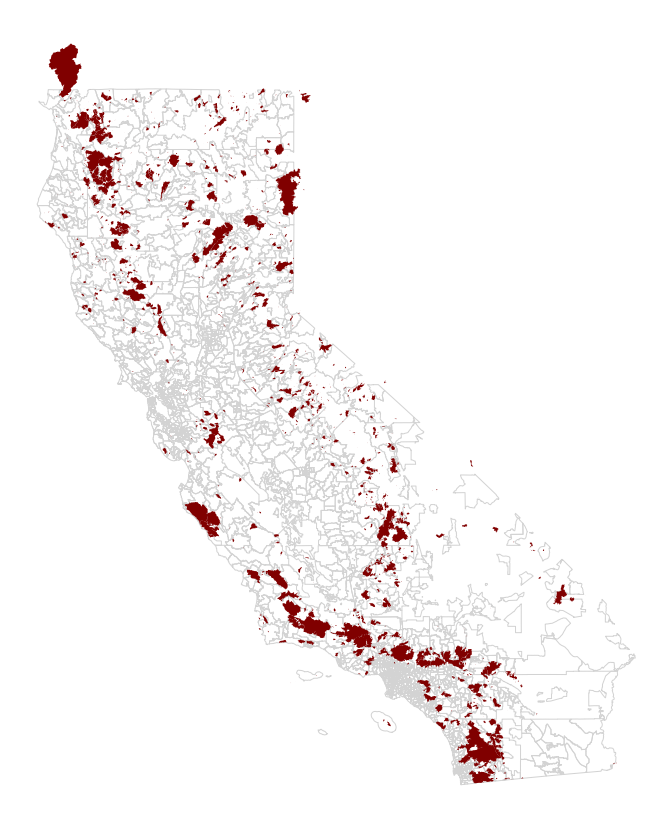

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
# plot base


fig, ax = plt.subplots(1, 1, figsize=(15,15))

gdf_zcta.plot(
    ax=ax,
    cmap=None,
    edgecolor='lightgrey',
    facecolor='none'
)

gdf_wide[gdf_wide.YEAR_.le(2012)].geometry.plot(
    ax=ax,
    facecolor='maroon',
)
# set axis off
ax.axis("off")

plt.savefig(out_dir + "Fig3c.pdf")

---

print example

In [9]:
gdf_wide[gdf_wide.FIRE_NAME=='PINE']

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,...,geometry,fire_centroid,ALARM_YEAR,CONT_YEAR,ALARM_MONTH,CONT_MONTH,SAME_MONTH_FIRE,FIRE_DURATION_MONTHS,FIRE_DURATION_DAYS,FIRE_AREA_KM2
464,2002,CA,CDF,MEU,PINE,00009436,2002-11-25,2002-11-28,5.0,,...,"MULTIPOLYGON (((-122.92471 38.87447, -122.9240...",POINT (-122.92424 38.86193),2002,2002,11,11,1,0,3,4.144031
670,2004,CA,CCO,LAC,PINE,00142168,2004-07-12,2004-07-23,9.0,,...,"MULTIPOLYGON (((-118.65353 34.78171, -118.6520...",POINT (-118.60679 34.74119),2004,2004,7,7,1,0,11,65.849038
857,2006,CA,USF,CNF,PINE,00001918,2006-07-14,2006-07-17,2.0,,...,"MULTIPOLYGON (((-116.54365 32.82445, -116.5433...",POINT (-116.54387 32.82174),2006,2006,7,7,1,0,3,0.496637
1019,2007,CA,CDF,LMU,PINE,00002692,2007-06-23,2007-07-29,5.0,Grass and Brush Mix,...,"MULTIPOLYGON (((-120.61995 40.36849, -120.6201...",POINT (-120.62789 40.36955),2007,2007,6,7,0,1,36,1.949691
1045,2007,CA,USF,CNF,PINE,00000073,2007-09-12,2007-10-02,4.0,,...,"MULTIPOLYGON (((-116.54337 32.80499, -116.5386...",POINT (-116.53422 32.78628),2007,2007,9,10,0,1,20,8.546009
1382,2009,CA,CDF,LNU,PINE,007027,2009-09-21,2009-09-25,14.0,,...,"MULTIPOLYGON (((-122.78363 38.76106, -122.7823...",POINT (-122.78434 38.75823),2009,2009,9,9,1,0,4,0.808135
2148,2016,CA,USF,LPF,PINE,001986,2016-06-30,2016-12-15,4.0,,...,"MULTIPOLYGON (((-119.22866 34.65951, -119.2287...",POINT (-119.23008 34.63862),2016,2016,6,12,0,6,168,9.308801
2455,2017,CA,CDF,LMU,PINE,00004312,2017-07-27,2017-07-31,1.0,None,...,"MULTIPOLYGON (((-120.42687 41.42946, -120.4268...",POINT (-120.42598 41.42742),2017,2017,7,7,1,0,4,0.085960


``long format``

i.e., add a row for each month a fire is active

In [20]:
gdf_long = clean_fires_long(gdf_wide)
gdf_long.head(2)

(4061, 6)


,fire_name,fire_year,fire_month,fire_area_km2,fire_duration_days,fire_centroid
0,BARTLETT,1991,1,0.181618,2.0,POINT (-122.77597 39.15535)
1,BEAR,1991,1,4.379187,4.0,POINT (-122.81094 39.60915)


print example

In [21]:
gdf_long[gdf_long.fire_name=='PINE']

,fire_name,fire_year,fire_month,fire_area_km2,fire_duration_days,fire_centroid
694,PINE,2002,11,4.144031,3.0,POINT (-122.92424 38.86193)
997,PINE,2004,7,65.849038,11.0,POINT (-118.60679 34.74119)
1269,PINE,2006,7,0.496637,3.0,POINT (-116.54387 32.82174)
1455,PINE,2007,6,1.949691,36.0,POINT (-120.62789 40.36955)
1478,PINE,2007,7,1.949691,36.0,POINT (-120.62789 40.36955)
1558,PINE,2007,9,8.546009,20.0,POINT (-116.53422 32.78628)
1588,PINE,2007,10,8.546009,20.0,POINT (-116.53422 32.78628)
2210,PINE,2009,9,0.808135,4.0,POINT (-122.78434 38.75823)
3435,PINE,2016,6,9.308801,168.0,POINT (-119.23008 34.63862)
3472,PINE,2016,7,9.308801,168.0,POINT (-119.23008 34.63862)


### Step 5: Export to .csv

In [ ]:
gdf_wide.to_csv(out_dir + 'fires_wide.csv')
gdf_long.to_csv(out_dir + 'fires_long.csv')